In [1]:
import os
import sys
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from database import db_api

from engine.classifiers import *
from engine.feature_engineering import *

db = db_api.db_api()

Setting database to ip: 127.0.0.1, port 3306


In [2]:
# What stats are available
stats = db.get_items('stats')
#for stat in stats:
#    print stat.name

Connected to database


In [3]:
# Retrieve all MSUs from the DB
msus = db.get_items('msus')
for msu in msus:
    print 'ID: ' + str(msu.msu) + ', TYPE: ' + msu.msu_type.name

Connected to database
ID: 10, TYPE: socket
ID: 11, TYPE: socket
ID: 12, TYPE: socket
ID: 13, TYPE: http
ID: 14, TYPE: http
ID: 15, TYPE: http
ID: 16, TYPE: read
ID: 17, TYPE: read
ID: 18, TYPE: read
ID: 19, TYPE: read
ID: 20, TYPE: read
ID: 21, TYPE: read
ID: 22, TYPE: read
ID: 23, TYPE: read
ID: 24, TYPE: read
ID: 25, TYPE: regex
ID: 26, TYPE: regex
ID: 27, TYPE: regex
ID: 28, TYPE: regex
ID: 29, TYPE: regex
ID: 30, TYPE: regex
ID: 31, TYPE: regex_route
ID: 32, TYPE: regex_route
ID: 33, TYPE: regex_route
ID: 34, TYPE: write
ID: 35, TYPE: write
ID: 36, TYPE: write


In [4]:

import json 
event_log_file = './event_log.json'
event_log = json.load(open(event_log_file))
events = pd.DataFrame([(e['time_'] * 1e9, e['status_'], e['name_']) for e in event_log], columns=('time', 'status', 'name'))
client_start = events.time[np.logical_and(events.status == 'start', events.name == 'client')].iloc[0]
attacks_start = events[np.logical_and(events.status == 'start', (events.name.isin(('slowloris', 'tls_reneg', 'redos'))))]
attacks_end = events[np.logical_and(events.status == 'end', (events.name.isin(('slowloris', 'tls_reneg', 'redos'))))]


attack_start = min(attacks_start.time)

attacks = []
for start, end in zip(attacks_start.iterrows(), attacks_end.iterrows()):
    attacks.append([start[1]['name'], start[1].time, end[1].time])
attacks = pd.DataFrame(attacks, columns=('name', 'start','end'))
    

read
Connected to database
Connected to database


/home/iped/miniconda2/envs/dedos/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


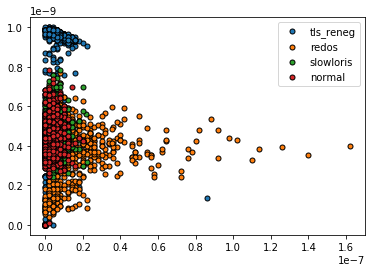

In [5]:
print msus[8].msu_type.name
df = db.get_msu_full_df(msus[8])
gen_stat_change_rate(df)

df['label'] = "normal"
for attack in attacks.iterrows():
    df.label[np.logical_and(df.TIME > attack[1].start - 10e9, df.TIME < attack[1].end + 60e9)] = attack[1]['name']

fix, ax = plt.subplots()
for name in ('tls_reneg', 'redos', 'slowloris','normal'):
    group = df[df.label == name]
    plt.plot(group['MSU_INVOL_CTX_SW'], group['MSU_USER_TIME'], 'o', markeredgecolor='k', markersize=5, label=name)
ax.legend()

In [6]:
print [x.name for x in db.get_items('stats')]

Connected to database
[u'QUEUE_LEN', u'ITEMS_PROCESSED', u'EXEC_TIME', u'IDLE_TIME', u'MEMORY_ALLOCATED', u'NUM_STATES', u'ERROR_COUNT', u'MSU_USER_TIME', u'MSU_KERNEL_TIME', u'MSU_MINOR_FAULTS', u'MSU_MAJOR_FAULTS', u'MSU_VOL_CTX_SW', u'MSU_INVOL_CTX_SW', u'USER_TIME', u'KERNAL_TIME', u'MAX_RSS', u'MINOR_FAULTS', u'MAJOR_FAULTS', u'VOL_CTX_SW', u'INVOL_CTX_SW']


In [7]:
print msus[8].msu_type.name
df = db.get_msu_full_df(msus[8])


# Some feature engineering
gen_activity_ratio(df)
gen_mem_per_state(df)

# Scale fields between {0,1}
scale_fields = ["MSU_USER_TIME", "MSU_KERNEL_TIME", "MSU_MINOR_FAULTS", "MSU_MAJOR_FAULTS", "MSU_VOL_CTX_SW", "MSU_INVOL_CTX_SW", 'EXEC_TIME', 'IDLE_TIME', 'QUEUE_LEN', 'MEMORY_ALLOCATED', 'MEM_PER_STATE']
normalize_df(df, scale_fields)

# Split train and test
fields = ["MSU_USER_TIME", "MSU_KERNEL_TIME", "MSU_MINOR_FAULTS", "MSU_MAJOR_FAULTS", "MSU_VOL_CTX_SW", "MSU_INVOL_CTX_SW", 'EXEC_TIME', 'IDLE_TIME', 'QUEUE_LEN', 'MEMORY_ALLOCATED', 'ACTIVITY_RATIO', 'MEM_PER_STATE']


X_train =  df[df.TIME <= attack_start].loc[:, fields]
X_test = df[df.TIME > attack_start].loc[:, fields]

read
Connected to database
Connected to database


/home/iped/miniconda2/envs/dedos/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [8]:
print df

          ERROR_COUNT  EXEC_TIME  IDLE_TIME    ITEMS_PROCESSED  \
0                0E-9   0.000000   0.000000               0E-9   
1                0E-9   0.000000   0.000000               0E-9   
2                0E-9   0.000000   0.000000               0E-9   
3                0E-9   0.000000   0.000000               0E-9   
4                0E-9   0.000000   0.000000               0E-9   
5                0E-9   0.000000   0.000000               0E-9   
6                0E-9   0.000000   0.000000               0E-9   
7                0E-9   0.000000   0.000000               0E-9   
8                0E-9   0.000000   0.000000               0E-9   
9                0E-9   0.000000   0.000000               0E-9   
10               0E-9   0.000000   0.000000               0E-9   
11               0E-9   0.000000   0.000000               0E-9   
12               0E-9   0.000000   0.000000               0E-9   
13               0E-9   0.000000   0.000000               0E-9   
14        

In [ ]:
### Setup for classification
from sklearn.model_selection import StratifiedKFold

df["LABEL"] = df.apply(lambda row: 0 if row["TIME"] < attack_start else 1, axis=1)
X = df[fields]
Y = df["LABEL"]

def calculate_acc(Y_pred, Y_true):
    num_errors = np.sum(np.abs(Y_pred-Y_true))
    return 1 - (num_errors * 1.0 / Y_pred.size)

def run_classification(clf, X, Y, n_splits):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True)
    for train_index, test_index in skf.split(X, Y):
        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
        Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
        trained_clf = clf.fit(X_train, Y_train)
        Y_pred = clf.predict(X_test)
        print(calculate_acc(Y_pred, Y_test))
    return clf.fit(X, Y)

In [ ]:
### Logistic regression ###
from sklearn import linear_model

logreg_clf = linear_model.LogisticRegression()
trained_clf = run_classification(logreg_clf, X, Y, 5)

In [ ]:
### Decision tree ###
from sklearn import tree
import graphviz

tree_clf = tree.DecisionTreeClassifier(max_depth=3, min_samples_leaf=5)
trained_clf = run_classification(tree_clf, X, Y, 5)
    
data = tree.export_graphviz(trained_clf, out_file=None, feature_names=fields, class_names=["NORMAL", "ATTACK"],
                            filled=True, rounded=True, special_characters=True)  
graph = graphviz.Source(data)
graph

/home/iped/miniconda2/envs/dedos/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


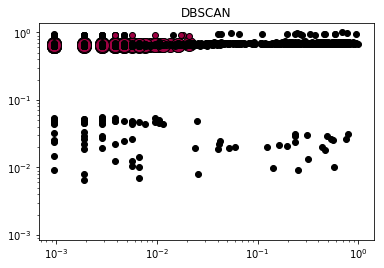

In [8]:
###DBSCAN###
X = pd.concat([X_train, X_test])

dbscan = do_dbscan(X, 0.3, 500)

core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True
labels = dbscan.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)
    
    ax = plt.subplot(111)
    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy.loc[:,'QUEUE_LEN'], xy.loc[:,'EXEC_TIME'], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X.loc[class_member_mask & ~core_samples_mask]
    plt.plot(xy.loc[:,'QUEUE_LEN'], xy.loc[:, 'EXEC_TIME'], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)
    ax.set_xscale("log")
    ax.set_yscale("log")

plt.title('DBSCAN')
plt.show()

In [ ]:
###LOF###
X = pd.concat([X_train,X_test])
lof = do_lof(500)
labels = lof.fit_predict(X)

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for outliers.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)
    
    xy = X[class_member_mask]
    plt.plot(xy.loc[:,'QUEUE_LEN'], xy.loc[:,'EXEC_TIME'], 'o', markerfacecolor=tuple(col),
             markeredgecolor='w', markersize=14)

    xy = X.loc[~class_member_mask]
    plt.plot(xy.loc[:,'QUEUE_LEN'], xy.loc[:, 'EXEC_TIME'], 'o', markerfacecolor=tuple(col),
             markeredgecolor='W', markersize=6)
    
plt.axis('tight')
plt.title('Local Outlier Factor (LOF)')
plt.show()

In [ ]:
###One Class SVM###
X = pd.concat([X_train,X_test])
svm = do_svm(X, 'rbf', 0.1)
labels = svm.predict(X)

#print labels
#print len(X[labels == -1])

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for outliers.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)
        
    xy = X[class_member_mask]
    plt.plot(xy.loc[:,'QUEUE_LEN'], xy.loc[:,'EXEC_TIME'], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X.loc[~class_member_mask]
    plt.plot(xy.loc[:,'QUEUE_LEN'], xy.loc[:, 'EXEC_TIME'], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)
    
plt.axis('tight')
plt.title('One Class SVM')
plt.show()

In [ ]:
### Isolation Forest###
X = pd.concat([X_train,X_test])
svm = do_isolation_forest(X, len(X), 42)
labels = svm.predict(X)

#print labels
#print len(X[labels == -1])

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for outliers.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)
        
    xy = X[class_member_mask]
    plt.plot(xy.loc[:,'QUEUE_LEN'], xy.loc[:,'EXEC_TIME'], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X.loc[~class_member_mask]
    plt.plot(xy.loc[:,'QUEUE_LEN'], xy.loc[:, 'EXEC_TIME'], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)
    
plt.axis('tight')
plt.title('Isolation Forest')
plt.show()